<a href="https://colab.research.google.com/github/jesst0x/image-segmentation-in-dark/blob/main/notebook/pre_trained_mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'AI/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path



In [5]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [6]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_segmentation_masks
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import ToTensor, PILToTensor

In [31]:
### Loading dataset
IMAGES_PATH = Path("/content/drive/MyDrive/AI/coco/coco_subset100_augmented")
ANNOTATIONS_PATH = Path("/content/drive/MyDrive/AI/coco/instances_train2017_subset100.json")

test_dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH, transform=ToTensor())
# test_dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [32]:
print(len(test_dataset))
print(test_dataset[0])

100
(tensor([[[0.0471, 0.0275, 0.0039,  ..., 0.0039, 0.0039, 0.0275],
         [0.0353, 0.0431, 0.0314,  ..., 0.0667, 0.0588, 0.0353],
         [0.0392, 0.0745, 0.0549,  ..., 0.0588, 0.0471, 0.0000],
         ...,
         [0.0235, 0.0196, 0.0588,  ..., 0.0157, 0.0549, 0.0392],
         [0.0157, 0.0196, 0.0667,  ..., 0.0196, 0.0549, 0.0392],
         [0.0000, 0.0078, 0.0667,  ..., 0.0000, 0.0314, 0.0157]],

        [[0.0275, 0.0196, 0.0000,  ..., 0.0039, 0.0039, 0.0275],
         [0.0157, 0.0353, 0.0314,  ..., 0.0667, 0.0588, 0.0353],
         [0.0314, 0.0667, 0.0549,  ..., 0.0588, 0.0471, 0.0000],
         ...,
         [0.0314, 0.0275, 0.0588,  ..., 0.0118, 0.0431, 0.0275],
         [0.0235, 0.0275, 0.0667,  ..., 0.0157, 0.0431, 0.0275],
         [0.0157, 0.0235, 0.0706,  ..., 0.0000, 0.0235, 0.0078]],

        [[0.0431, 0.0314, 0.0078,  ..., 0.0118, 0.0118, 0.0353],
         [0.0314, 0.0471, 0.0392,  ..., 0.0745, 0.0667, 0.0431],
         [0.0353, 0.0706, 0.0549,  ..., 0.0667, 0.054

In [33]:
test_dataset = datasets.wrap_dataset_for_transforms_v2(test_dataset, target_keys=("all"))

In [34]:
sample = test_dataset[0]
img, target = sample
print(target)

{'image_id': 1739, 'boxes': BoundingBoxes([[103.3700, 251.4300, 506.7100, 388.2400]], format=BoundingBoxFormat.XYXY, canvas_size=(453, 640)), 'masks': Mask([[[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'labels': tensor([8]), 'iscrowd': [0], 'segmentation': [[[103.37, 368.98, 106.41, 317.3, 118.57, 251.43, 129.72, 277.78, 144.92, 261.56, 404.36, 258.52, 418.54, 276.76, 502.66, 320.34, 506.71, 385.2, 465.16, 388.24, 391.18, 379.12, 232.07, 377.09, 115.53, 380.13]]], 'area': [43937.93609999999], 'category_id': [8], 'bbox': [[103.37, 251.43, 403.34, 136.81]]}


In [35]:
from torch.utils.data import DataLoader
import utils
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=utils.collate_fn,
)

8
8
Feature batch shape: 8
Labels batch shape: 8


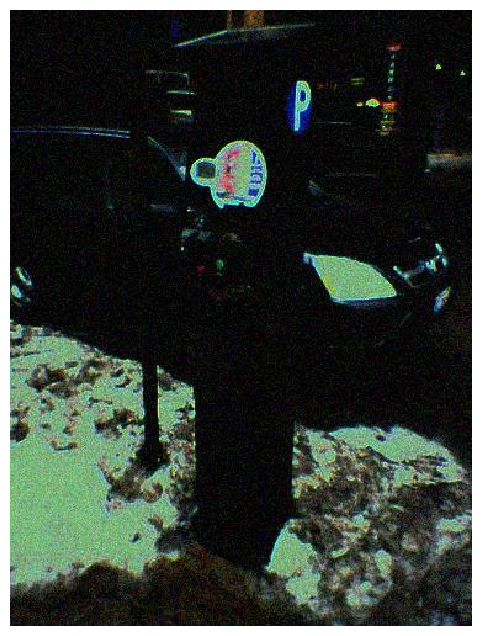

Label: {'image_id': 302200, 'boxes': BoundingBoxes([[  0.0000,  89.5900, 370.2500, 286.4600],
               [243.5000,  89.4000, 321.9300, 136.9500],
               [126.6800,   6.6700, 267.9400, 320.5700],
               [ 15.3700,  47.4200, 155.4700, 102.1100]], format=BoundingBoxFormat.XYXY, canvas_size=(500, 375)), 'masks': Mask([[[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],


In [36]:
test_features, test_labels = next(iter(test_dataloader))
print(len(test_features))
print(len(test_labels))
print(f"Feature batch shape: {len(test_features)}")
print(f"Labels batch shape: {len(test_labels)}")
img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.axis("off")
plt.show()
print(f"Label: {label}")

In [37]:
print(test_features[0].shape)
print(test_labels[0])

torch.Size([3, 500, 375])
{'image_id': 302200, 'boxes': BoundingBoxes([[  0.0000,  89.5900, 370.2500, 286.4600],
               [243.5000,  89.4000, 321.9300, 136.9500],
               [126.6800,   6.6700, 267.9400, 320.5700],
               [ 15.3700,  47.4200, 155.4700, 102.1100]], format=BoundingBoxFormat.XYXY, canvas_size=(500, 375)), 'masks': Mask([[[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 

In [38]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
model = maskrcnn_resnet50_fpn(weights=weights, progress=False)

In [42]:
from engine import train_one_epoch, evaluate
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [43]:
evaluate(model, test_dataloader, device=device)

Test:  [ 0/13]  eta: 0:00:35  model_time: 1.5741 (1.5741)  evaluator_time: 0.2506 (0.2506)  time: 2.7254  data: 0.8939  max mem: 11199
Test:  [12/13]  eta: 0:00:03  model_time: 1.5741 (1.5112)  evaluator_time: 0.2506 (0.3048)  time: 3.9042  data: 2.0718  max mem: 11199
Test: Total time: 0:00:50 (3.9044 s / it)
Averaged stats: model_time: 1.5741 (1.5112)  evaluator_time: 0.2506 (0.3048)
Accumulating evaluation results...
DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.39s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.169
 Average Rec

In [45]:
#### Not augmented test set
ORIGINAL_IMAGES_PATH = Path("/content/drive/MyDrive/AI/coco/coco_subset100")
original_dataset = datasets.CocoDetection(ORIGINAL_IMAGES_PATH, ANNOTATIONS_PATH, transform=ToTensor())
original_dataset = datasets.wrap_dataset_for_transforms_v2(original_dataset, target_keys=("all"))
original_dataloader = torch.utils.data.DataLoader(
    original_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=utils.collate_fn,
)
evaluate(model, original_dataloader, device=device)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Test:  [ 0/13]  eta: 0:01:39  model_time: 1.3379 (1.3379)  evaluator_time: 0.2672 (0.2672)  time: 7.6897  data: 6.0775  max mem: 11199
Test:  [12/13]  eta: 0:00:07  model_time: 1.5803 (1.6058)  evaluator_time: 0.3723 (0.4433)  time: 7.7685  data: 5.6947  max mem: 12837
Test: Total time: 0:01:40 (7.7687 s / it)
Averaged stats: model_time: 1.5803 (1.6058)  evaluator_time: 0.3723 (0.4433)
Accumulating evaluation results...
DONE (t=0.86s).
Accumulating evaluation results...
DONE (t=0.80s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.791
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.637
 Average 